In [ ]:
## idea is to build a language model that takes text input and generates text output, possibly completes the input text
## use embeddings from sentence transformers as input so that we don't have to learn them again



# first use last n tokens as input and generate next word
# now to generate text, just keep predicting next word using predictions of previous words

# how does chat gpt works then ?

In [1]:
!pip install torch

In [2]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=bf9b92a8d45d253d46dfdb75fc8347fac8103fdc913696306d8ce41eaf44f5e5
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [37]:
import pandas as pd
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel
import matplotlib.pyplot as plt
import time
from tqdm import tqdm


In [5]:
path = "/content/drive/MyDrive/Colab Notebooks/ds_projects/articles.csv"
data_df = pd.read_csv(path)

In [6]:
data_df.head(2)

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...


In [8]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [9]:
tokens = tokenizer(["hello how are you doing"])

In [10]:
tokens

{'input_ids': [[101, 7592, 2129, 2024, 2017, 2725, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}

# Convert text into token ids using tokenizer

In [11]:
sentence_tokens_dataset = tokenizer(list(data_df["text"].values))

Token indices sequence length is longer than the specified maximum sequence length for this model (2639 > 512). Running this sequence through the model will result in indexing errors


In [12]:
len(sentence_tokens_dataset["input_ids"])

337

# Prepare Training dataset for modeling
* input -> list of tokens in order
* output -> list of tokens in order

In [14]:
data_df["sentence"] = data_df["text"] + ":::" + data_df["title"]

In [15]:
sentences = data_df["sentence"].values

In [16]:
input_sentences = []
output_sentences = []
window_size = 50
for sentence in sentences:
  tokenized = tokenizer(sentence, truncation=True, padding="longest")["input_ids"]
  for i in range(len(tokenized) - window_size):
    input_sentences.append(torch.tensor(tokenized[i:i+window_size]))
    output_sentences.append(torch.tensor(tokenized[i+window_size]))

In [17]:
len(input_sentences), len(output_sentences)

(154786, 154786)

In [18]:
tokenizer.decode(tokenizer.sep_token_id), tokenizer.decode(tokenizer.cls_token_id)

('[SEP]', '[CLS]')

In [19]:
class LanguageModelDataset(Dataset):
    def __init__(self, input_sentences, output_sentences):
        self.input_sentences = input_sentences
        self.output_sentences = output_sentences

    def __len__(self):
        return len(self.input_sentences)

    def __getitem__(self, index):
        return torch.LongTensor(input_sentences[index]), torch.LongTensor(output_sentences[index])

In [20]:
len(sentences)

337

In [21]:
WINDOW_SIZE = 50

In [22]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [23]:
topN = 10000

In [24]:
len(input_sentences)

154786

In [25]:
dataset = LanguageModelDataset(input_sentences=input_sentences,
                               output_sentences=output_sentences)

In [26]:
batch_size = 16
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [27]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, num_layers):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.transformer_block = nn.TransformerEncoderLayer(
            d_model = embedding_size,
            nhead=num_heads,
            dim_feedforward=embedding_size * num_heads)
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_block, num_layers)
        self.linear_layer = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        pooled_output = transformer_output.mean(dim=1)
        logits = self.linear_layer(pooled_output)
        return logits

In [28]:
vocab_size = len(tokenizer)
embedding_size = 32
num_heads = 2
num_layers = 1

In [35]:
model = LanguageModel(vocab_size, embedding_size, num_heads, num_layers)

In [36]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LanguageModel(
  (embedding): Embedding(30522, 32)
  (transformer_block): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (linear1): Linear(in_features=32, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=64, out_features=32, bias=True)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1,

## Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

num_epochs = 5

for epoch in range(num_epochs):
  model.train() # training mode initiated with this
  train_loss = 0.0

  start_time = time.time()
  for input_ids, target_ids in tqdm(data_loader):
    input_ids = input_ids.to(device)
    target_ids = target_ids.squeeze().to(device)
    optimizer.zero_grad()
    output = model(input_ids)
    loss = criterion(output, target_ids)
    loss.backward() # compute backpropagation
    optimizer.step() # update weights

    train_loss = train_loss + loss.item()
  end_time = time.time()
  print(f"Epoch: {epoch}, time taken: {(end_time - start_time) / 60}")
  train_loss = train_loss / len(data_loader)
  print(f"Epoch: {epoch}/ {num_epochs}, Train loss: {train_loss:.4f}")

100%|██████████| 9675/9675 [05:49<00:00, 27.69it/s]


Epoch: 0, time taken: 5.823178617159526
Epoch: 0/ 5, Train loss: 5.4300


100%|██████████| 9675/9675 [05:42<00:00, 28.21it/s]


Epoch: 1, time taken: 5.7159450848897295
Epoch: 1/ 5, Train loss: 5.3986


100%|██████████| 9675/9675 [05:39<00:00, 28.51it/s]


Epoch: 2, time taken: 5.656171329816183
Epoch: 2/ 5, Train loss: 5.3681


100%|██████████| 9675/9675 [05:50<00:00, 27.62it/s]


Epoch: 3, time taken: 5.838200644652049
Epoch: 3/ 5, Train loss: 5.3431


100%|██████████| 9675/9675 [05:44<00:00, 28.07it/s]

Epoch: 4, time taken: 5.745600231488546
Epoch: 4/ 5, Train loss: 5.3186


In [ ]:
# Set the model to evaluation mode
model.eval()

# Function to generate a sentence given an input sentence
def generate_sentence(input_sentence, model, tokenizer, max_length=25):
    # Tokenize the input sentence
    input_tokens = tokenizer(input_sentence, truncation=True, padding="longest")["input_ids"]

    input_tokens = input_tokens[1:-1] # remove start and end tokens [CLS] and [SEP]

    # Add batch dimension and move to the appropriate device
    input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)

    # Generate output
    with torch.no_grad():
        output_tokens = [input_tokens]
        for _ in range(max_length):
            output = model(input_tokens)
            predicted_token = torch.argmax(output, dim=-1)
            output_tokens.append(predicted_token.unsqueeze(0))
            input_tokens = torch.cat(output_tokens, dim=1)
    generated_tokens = input_tokens[0].unsqueeze(0).tolist()[0]
    generated_sentence = tokenizer.decode(generated_tokens)

    return generated_sentence

In [ ]:
# Example usage
input_sentence = "What is deep learning"
generated_sentence = generate_sentence(input_sentence, model, tokenizer)

print("Input:", input_sentence)
print("Generated:", generated_sentence)

Input: What is deep learning
Generated: what is deep learning means means of. is is means is means of to learn learn means. means the the of learn means of learn means learn


In [ ]:
def get_similarity(word1, word2):
  return model.embedding(torch.tensor(tokenizer.vocab[word1])).dot(model.embedding(torch.tensor(tokenizer.vocab[word2])))

In [ ]:
get_similarity("good", "bad")

tensor(-0.6377, grad_fn=<DotBackward0>)

In [ ]:
tokenizer.decode([  101,  1045,  2066,  2000,  2147,  2006, 11834, 27014,  1012,   102,
          1056,  1010,  1010,  1045,  1045,  1045,  1045,  1049,  1045,  1045,
          1045,  1045,  1049,  1045,  1045,  1045,  1045,  1049,  1045,  1045,
          1045,  1045,  1049,  1045,  1045,  1045,  1045,  1049,  1045,  1045,
          1045,  1045,  1049,  1045,  1045,  1045,  1045,  1049,  1045,  1045,
          1045,  1045,  1049,  1045,  1045,  1045,  1045,  1049,  1045])

'[CLS] i like to work on chatbots. [SEP] t,, i i i i m i i i i m i i i i m i i i i m i i i i m i i i i m i i i i m i i i i m i i i i m i'

In [ ]:
tokenizer.decode(input_sentences[2].tolist())

', how the headlines blared : chatbots were the next big thing. our hopes were sky high. bright - eyed and bushy - tailed, the industry was ripe for a new era of innovation : it was time to start socializing with'

In [ ]:
input_tokens = tokenizer("I want to drink coffee", truncation=True, padding="longest")["input_ids"]

In [ ]:
input_tokens

[101, 1045, 2215, 2000, 4392, 4157, 102]

In [ ]:
tokenizer.decode(input_tokens[1:-1])

'i want to drink coffee'

In [ ]:
tokenizer.decode(input_tokens)

'[CLS] i want to drink coffee [SEP]'

# Use Sentence Encoder Embeddings

In [ ]:
embedding_model = AutoModel.from_pretrained(model_name)

In [ ]:
input_tokens = [101, 1045, 2215, 2000, 4392, 4157, 102] # we can get this from tokeznier -> use tokenizer and embeddings from same model
input_ids = torch.tensor(input_tokens).unsqueeze(0)

with torch.no_grad():
  embeddings = embedding_model(input_ids)["last_hidden_state"]
  print(input_ids.shape)
  print(embeddings.shape)

torch.Size([1, 7])
torch.Size([1, 7, 384])


In [ ]:
class LanguageModelWithEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_model, num_heads, num_layers):
        super(LanguageModelWithEmbeddingModel, self).__init__()
        self.embedding_model = embedding_model
        self.embedding_size = self.embedding_model.config.hidden_size
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model = self.embedding_size,
            nhead=num_heads,
            dim_feedforward=self.embedding_size * num_heads)
        self.transformer_block = nn.TransformerEncoder(
            self.transformer_encoder, num_layers)
        self.linear_layer = nn.Linear(self.embedding_size, vocab_size)
        self.__add_names() # does not work

    def forward(self, x):
        embedded = self.embedding_model(x)["last_hidden_state"]
        transformer_output = self.transformer_block(embedded)
        pooled_output = transformer_output.mean(dim=1)
        logits = self.linear_layer(pooled_output)
        return logits

    def __add_names(self):
      self.transformer_encoder.name = "transformer_encoder"
      self.transformer_block.name = "transformer_block"
      self.linear_layer.name = "output_layer"

In [ ]:
class LanguageModelWithEmbeddingModelWithName(nn.Module):
    def __init__(self, vocab_size, embedding_model, num_heads, num_layers):
        super(LanguageModelWithEmbeddingModelWithName, self).__init__()

        self.embedding_model = embedding_model
        self.embedding_size = self.embedding_model.config.hidden_size

        self.add_module("transformer_encoder", nn.TransformerEncoderLayer(
            d_model = self.embedding_size,
            nhead=num_heads,
            dim_feedforward=self.embedding_size * num_heads))

        self.add_module("transformer_block", nn.TransformerEncoder(
            self.transformer_encoder, num_layers
        ))
        self.add_module("linear_layer", nn.Linear(self.embedding_size, vocab_size))

    def forward(self, x):
        embedded = self.embedding_model(x)["last_hidden_state"]
        transformer_output = self.transformer_block(embedded)
        pooled_output = transformer_output.mean(dim=1)
        logits = self.linear_layer(pooled_output)
        return logits

In [ ]:
batch_size = 8
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [ ]:
model_with_trained_embeddings = LanguageModelWithEmbeddingModel(vocab_size,
                                                                embedding_model, num_heads, num_layers)

In [ ]:
model_with_trained_embeddings_with_name = LanguageModelWithEmbeddingModelWithName(vocab_size,
                                                                embedding_model, num_heads, num_layers)

In [ ]:
import time
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

num_epochs = 5

for epoch in range(num_epochs):
  model_with_trained_embeddings.train() # training mode initiated with this
  train_loss = 0.0

  start_time = time.time()
  for input_ids, target_ids in tqdm(data_loader):
    input_ids = input_ids.to(device)
    target_ids = target_ids.squeeze().to(device)
    optimizer.zero_grad()
    output = model_with_trained_embeddings(input_ids)
    loss = criterion(output, target_ids)
    loss.backward() # compute backpropagation
    optimizer.step() # update weights

    train_loss = train_loss + loss.item()
  end_time = time.time()
  print(f"Epoch: {epoch}, time taken: {(end_time - start_time) / 60}")
  train_loss = train_loss / len(data_loader)
  print(f"Epoch: {epoch}/ {num_epochs}, Train loss: {train_loss:.4f}")

  0%|          | 18/19349 [00:19<5:43:50,  1.07s/it]


KeyboardInterrupt: ignored

In [ ]:
def get_number_of_parms(model):
  total_params = 0
  for name, param in model.named_parameters():
    print(f"name: {param.name}")
    print(f"size: {param.size()}")
    print(f"size: {param.numel()}")
    total_params += param.numel()
  print(f"Total parameters: {total_params}")

In [ ]:
get_number_of_parms(model_with_trained_embeddings_with_name)

name: None
size: torch.Size([30522, 384])
size: 11720448
name: None
size: torch.Size([512, 384])
size: 196608
name: None
size: torch.Size([2, 384])
size: 768
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384, 384])
size: 147456
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384, 384])
size: 147456
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384, 384])
size: 147456
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384, 384])
size: 147456
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([1536, 384])
size: 589824
name: None
size: torch.Size([1536])
size: 1536
name: None
size: torch.Size([384, 1536])
size: 589824
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Size([384])
size: 384
name: None
size: torch.Si

In [31]:
#get_number_of_parms(model_with_trained_embeddings)

In [ ]:
36831930 / 1000000

36.83193

# Understand Gradients

In [51]:
def plot_grad_flow(named_parameters):
  average_grads = []
  layers = []
  for n, p in named_parameters:
    if(p.requires_grad) and ("bias" not in n):
      if p.grad is not None:
        layers.append(n)
        average_grads.append(p.grad.abs().mean())
  plt.plot(average_grads, alpha=0.3, color = "b")
  plt.hlines(0, 0, len(average_grads) + 1, linewidth = 1, color="k")
  plt.xticks(range(0, len(average_grads), 1), layers, rotation = "vertical")
  plt.xlim(xmin=0, xmax=len(average_grads))
  plt.xlabel("Layers")
  plt.ylabel("Average Gradient")
  plt.title("Gradient Flow")
  plt.grid(True)

In [57]:
import numpy as np
from matplotlib.lines import Line2D

## Better Implementation - https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
def plot_grad_flow_different(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
          if p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

100%|██████████| 9675/9675 [14:41<00:00, 10.97it/s]


Epoch: 0, time taken: 14.698262929916382
Epoch: 0/ 1, Train loss: 6.8286


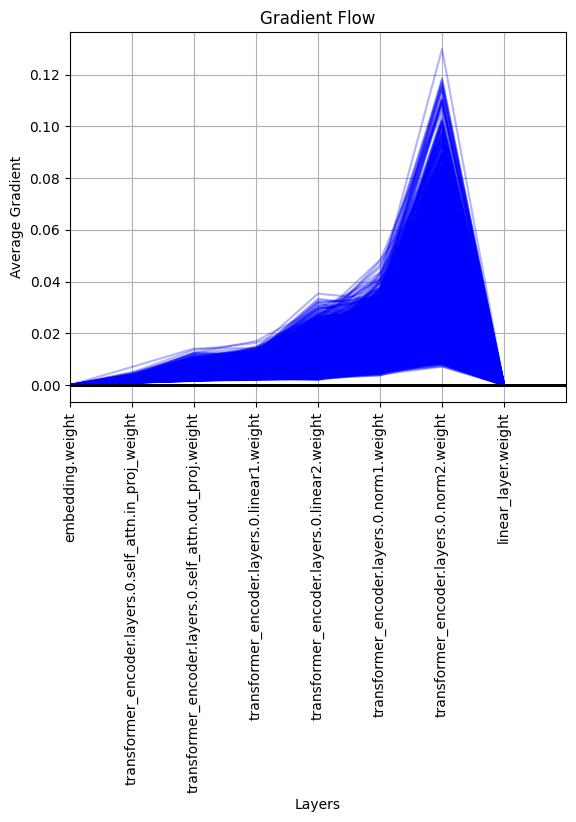

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

num_epochs = 1

for epoch in range(num_epochs):
  model.train() # training mode initiated with this
  train_loss = 0.0

  start_time = time.time()
  for input_ids, target_ids in tqdm(data_loader):
    input_ids = input_ids.to(device)
    target_ids = target_ids.squeeze().to(device)
    optimizer.zero_grad()
    output = model(input_ids)
    loss = criterion(output, target_ids)
    loss.backward() # compute backpropagation
    optimizer.step() # update weights
    plot_grad_flow(model.named_parameters())

    train_loss = train_loss + loss.item()
  end_time = time.time()
  print(f"Epoch: {epoch}, time taken: {(end_time - start_time) / 60}")
  train_loss = train_loss / len(data_loader)
  print(f"Epoch: {epoch}/ {num_epochs}, Train loss: {train_loss:.4f}")

100%|██████████| 9675/9675 [13:45<00:00, 11.71it/s]


Epoch: 0, time taken: 13.76492885351181
Epoch: 0/ 1, Train loss: 6.5778


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


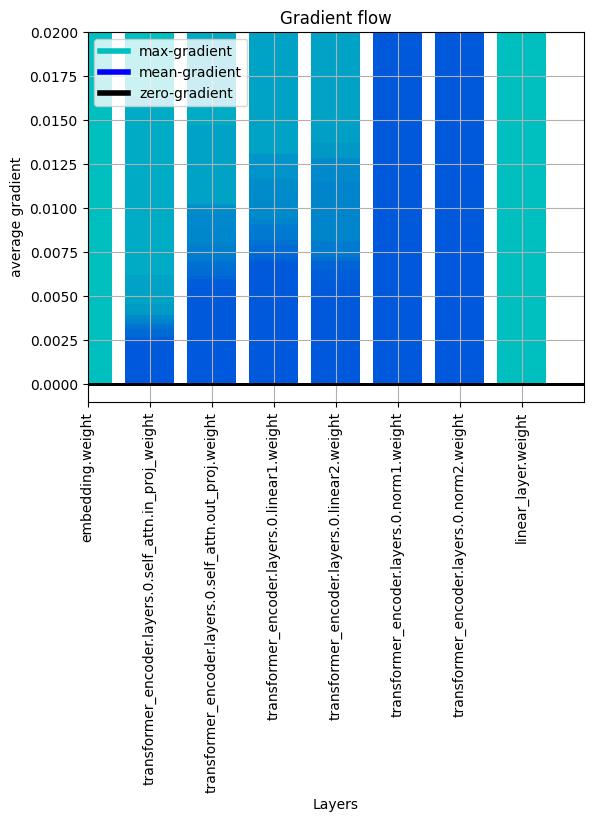

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

num_epochs = 1

for epoch in range(num_epochs):
  model.train() # training mode initiated with this
  train_loss = 0.0

  start_time = time.time()
  for input_ids, target_ids in tqdm(data_loader):
    input_ids = input_ids.to(device)
    target_ids = target_ids.squeeze().to(device)
    optimizer.zero_grad()
    output = model(input_ids)
    loss = criterion(output, target_ids)
    loss.backward() # compute backpropagation
    optimizer.step() # update weights
    plot_grad_flow_different(model.named_parameters())

    train_loss = train_loss + loss.item()
  end_time = time.time()
  print(f"Epoch: {epoch}, time taken: {(end_time - start_time) / 60}")
  train_loss = train_loss / len(data_loader)
  print(f"Epoch: {epoch}/ {num_epochs}, Train loss: {train_loss:.4f}")